In this notebook, I will also leverage a conservation mask to remove regions with too little data

This is repeated in a more concise and better documented manner in notebook 3, so read through that if you are reading through the heterozygosity notebooks

In [1]:
%run ../scripts/notebook_settings_lean.py
import glob

In [2]:
window_size = 1000000

In [3]:
glob_list = glob.glob("../steps/het_stats/temp/*window1000000.txt")

In [4]:
df_l = []
id_list = []
species_list = []
match_list = []
X_med_het, X_mean_het, X_upper_quart = [], [], []
aut_med_het, aut_mean_het = [], []
import glob
glob_list = glob.glob("../steps/het_stats/temp/*window1000000.txt")
for p in glob_list:
    df_l.append(pd.read_csv(p))
    if len(df_l) % 100 == 0:
        print((len(df_l)*100)//len(glob_list), "%")

4 %
9 %
14 %
18 %
23 %
28 %
33 %
37 %
42 %
47 %
52 %
56 %
61 %
66 %
71 %
75 %
80 %
85 %
90 %
94 %
99 %


In [5]:
mb_df = pd.concat(df_l)
mb_df["chrtype"] = ["autosome" if (x != "chrX" and x != "chrY")
                    else "chrY" if x == "chrY" else "chrX" for x in mb_df.chr]

In [6]:
metadata_path ="/home/eriks/primatediversity/data/PGDP_16_7_2020/metadata/"
meta_data_samples = pd.read_excel(metadata_path+"PGDP_md.16.7.2020.xlsx")
meta_data_baboons = pd.read_csv("/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/data/Papio_metadata_with_clustering.txt", sep =" ")
sex_cov = pd.read_csv(metadata_path+"sex_via_coverage_Lukas.csv")
meta_data_samples["PGDP_ID"] = meta_data_samples["PDGP_ID"]

In [11]:
ID_l = []
sex_l = []
for ID in meta_data_samples.PGDP_ID:
    ID_l.append(ID)
    if ID in sex_cov.PGDP_ID.values:
        if sex_cov.loc[sex_cov.PGDP_ID == ID].X_over_autosome_ratio.values > 0.8:
            sex_l.append("F")
        else:
            sex_l.append("M")
    elif ID in meta_data_baboons.PGDP_ID.values:
        sex_l.append(meta_data_baboons.loc[meta_data_baboons.PGDP_ID == ID].Sex.values)
    elif ID in ["PD_0012", "PD_0168", "PD_0169", "PD_0171"]:
        sex_l.append("F")
    else:
        sex_l.append("U")
meta_data_samples["SEX"] = sex_l

In [12]:
df_meta_ID = mb_df.loc[mb_df.PGDP_ID.isin(meta_data_samples.PGDP_ID.values)]

Loading bed files for use as a mask

In [9]:
bed_path = "../data/conservation_beds/{}.bed"
window_size = 1000000
df_l = []
for chrom in mb_df.chr.unique():
    df = pd.DataFrame()
    print(chrom)
    chrom_mask = pd.read_csv(bed_path.format(chrom), sep='\t', comment='t', header=None)
    mask_header = ['chrom', 'start', 'end', 'name']
    chrom_mask.columns = mask_header
    mask_percentage_l, window_l, chr_l = [], [], []
    for i in range(0, chrom_mask.end[len(chrom_mask)-1], window_size):
        mask_subset = chrom_mask.loc[(chrom_mask.end >= i) & (chrom_mask.start < i+window_size)]
        if len(mask_subset) == 0:
            mask_percentage_l.append(0)
        else:
            start_sum, end_sum = sum(mask_subset.start), sum(mask_subset.end)
            if mask_subset.start.iloc[0] < i:
                start_sum=start_sum-mask_subset.start.iloc[0]+i
            if mask_subset.end.iloc[-1] > i+window_size:
                end_sum=end_sum-mask_subset.end.iloc[-1]+i+window_size
            mask_percentage_l.append((end_sum-start_sum)/window_size)
        window_l.append(i), chr_l.append(chrom)
    df["mask_percentage"] = mask_percentage_l
    df["window"] = window_l
    df["chr"] = chr_l
    df_l.append(df)
mask_df = pd.concat(df_l)

chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr1
chr20
chr21
chr22
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chrX
chrY


In [10]:
#mask_df.to_csv("../steps/het_stats/mask_windows1000000.txt")

In [11]:
mask_df["chrtype"] = ["autosome" if (x != "chrX" and x != "chrY")
                    else "chrY" if x == "chrY" else "chrX" for x in mask_df.chr]

In [12]:
mask_df.groupby(["chrtype"]).mean()

,mask_percentage,window
chrtype,,
autosome,0.926763,7.739917e+07
chrX,0.950890,7.800000e+07
chrY,0.412662,2.850000e+07


Text(0.5, 1.0, 'Conservation in Megabase windows')

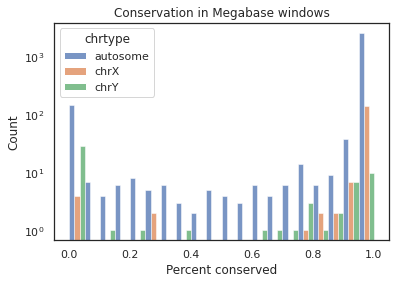

In [13]:
g = sns.histplot(data=mask_df, x="mask_percentage", hue="chrtype", multiple="dodge", bins=20)
g.set_yscale("log")
g.set_xlabel("Percent conserved")
g.set_title("Conservation in Megabase windows")

Reading in the het data

In [14]:
df_l = []
id_list = []
species_list = []
match_list = []
X_med_het, X_mean_het, X_upper_quart = [], [], []
aut_med_het, aut_mean_het = [], []
import glob
glob_list = glob.glob("../steps/het_stats/temp/*window1000000.txt")
for p in glob_list:
    df_l.append(pd.read_csv(p))
    if len(df_l) % 250 == 0:
        print((len(df_l)*100)//len(glob_list), "%")
mb_df = pd.concat(df_l)
mb_df["chrtype"] = ["autosome" if (x != "chrX" and x != "chrY")
                    else "chrY" if x == "chrY" else "chrX" for x in mb_df.chr]

11 %
23 %
35 %
47 %
59 %
71 %
82 %
94 %


Adding the conservation information.

In [15]:
mb_mask = df_meta_ID.merge(mask_df)

In [16]:
mb_masked = mb_mask.loc[mb_mask.mask_percentage > 0.9]

In [17]:
len(mb_masked)/len(mb_mask)

0.9080258497890458

Metadata

In [18]:
metadata_path ="/home/eriks/primatediversity/data/PGDP_16_7_2020/metadata/"
meta_data_samples = pd.read_excel(metadata_path+"PGDP_md.16.7.2020.xlsx")
meta_data_baboons = pd.read_csv("/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/data/Papio_metadata_with_clustering.txt", sep =" ")
sex_cov = pd.read_csv(metadata_path+"sex_via_coverage_Lukas.csv")
meta_data_samples["PGDP_ID"] = meta_data_samples["PDGP_ID"]
ID_l = []
sex_l = []
for ID in meta_data_samples.PGDP_ID:
    ID_l.append(ID)
    if ID in sex_cov.PGDP_ID.values:
        if sex_cov.loc[sex_cov.PGDP_ID == ID].X_over_autosome_ratio.values > 0.8:
            sex_l.append("F")
        else:
            sex_l.append("M")
    elif ID in meta_data_baboons.PGDP_ID.values:
        sex_l.append(meta_data_baboons.loc[meta_data_baboons.PGDP_ID == ID].Sex.values)
    elif ID in ["PD_0012", "PD_0168", "PD_0169", "PD_0171"]:
        sex_l.append("F")
    else:
        sex_l.append("U")
meta_data_samples["SEX"] = sex_l

In [19]:
mb_females = mb_masked.loc[mb_masked.PGDP_ID.isin(meta_data_samples.loc[meta_data_samples.SEX == "F"].PGDP_ID)]

Calculating summary stats for the females

In [20]:
mb_females

,lines,GQ_pass,ADFrac_pass,both_pass,PGDP_ID,species,match_type,chr,window,chrtype,mask_percentage
0,1954,832,481,480,PD_0331,Pithecia_pithecia,refmatch,chr10,0,autosome,0.979690
1,1458,970,114,114,PD_0140,Ateles_fusciceps,altmatch,chr10,0,autosome,0.979690
3,4176,3803,78,78,PD_0610,Lemur_catta,altmatch,chr10,0,autosome,0.979690
6,606,434,84,84,PD_0038,Rhinopithecus_strykeri,nomatch,chr10,0,autosome,0.979690
8,1808,1530,71,71,PD_0611,Lemur_catta,nomatch,chr10,0,autosome,0.979690
...,...,...,...,...,...,...,...,...,...,...,...
6217866,57,34,8,8,PD_0082,Pithecia_pithecia,refmatch,chrY,24000000,chrY,0.965291
6217869,0,0,0,0,PD_0171,proCoq1,altmatch,chrY,24000000,chrY,0.965291
6217870,59,31,2,2,PD_0621,Lemur_catta,altmatch,chrY,24000000,chrY,0.965291
6217872,3,2,1,1,PD_0416,Ateles_fusciceps,altmatch,chrY,24000000,chrY,0.965291


Text(0.5, 1.0, 'Conservation in Megabase windows')

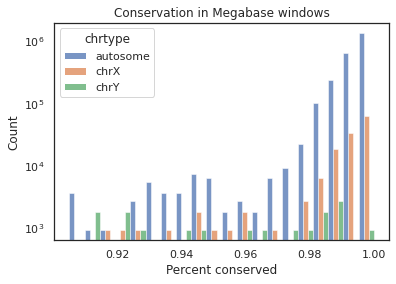

In [21]:
g = sns.histplot(data=mb_females, x="mask_percentage", hue="chrtype", multiple="dodge", bins=20)
g.set_yscale("log")
g.set_xlabel("Percent conserved")
g.set_title("Conservation in Megabase windows")

In [22]:
IDs = sorted(mb_females.PGDP_ID.unique())
cutoff = 1.5
for ID in []:#IDs:
    plt.clf()
    df_s = mb_females.loc[(mb_females.PGDP_ID == ID) &
                          (mb_females.match_type != "nomatch") &
                          (mb_females.chrtype != "chrY")].reset_index()
    alt_ref_df = df_s.set_index(df_s.index//2).sum(level=0)
    alt_ref_df["chrtype"] = (df_s.loc[df_s.match_type == "refmatch"].chrtype).reset_index(drop=True)
    alt_ref_df["window"] = alt_ref_df.window/2
    g = sns.histplot(alt_ref_df, x="both_pass", hue="chrtype", stat="probability",
                     common_norm=False, multiple="dodge", bins=40)
    plt.savefig("../steps/histograms/{}_hist.png".format(ID))

In [23]:
IDs = sorted(mb_females.PGDP_ID.unique())
x_a_ratio, x_het, aut_het, std_x, std_aut = [], [], [], [], []
nomatch_size_x, prune_size_x, keep_size_x = [], [], []
nomatch_size_aut, prune_size_aut, keep_size_aut = [], [], []

for ID in IDs:
    cutoff = 1.5
    df_s = mb_females.loc[(mb_females.PGDP_ID == ID) &
                          (mb_females.match_type != "nomatch")].reset_index()
    alt_ref_df = df_s.set_index(df_s.index//2).sum(level=0)
    alt_ref_df["chrtype"] = (df_s.loc[df_s.match_type == "refmatch"].chrtype).reset_index(drop=True)
    alt_ref_df["window"] = alt_ref_df.window/2
    aut = alt_ref_df.loc[(alt_ref_df.chrtype == "autosome")]
    std, mean = aut.GQ_pass.std(), aut.GQ_pass.mean()
    print(ID, mean, std)
    prune_aut = aut.loc[aut.GQ_pass > mean-cutoff*std]
    a_het = prune_aut.both_pass.mean()
    std_aut.append(prune_aut.both_pass.std())
    aut_het.append(a_het)
    keep_size_aut.append(len(prune_aut))
    prune_size_aut.append(len(aut)-len(prune_aut))
    x = alt_ref_df.loc[(alt_ref_df.chrtype == "chrX") &
                              (alt_ref_df.window >= 2700000)]
    std, mean = x.GQ_pass.std(), x.GQ_pass.mean()
    print(mean, std)
    prune_x = x.loc[x.GQ_pass > mean-cutoff*std]
    x_het.append(prune_x.both_pass.mean())
    std_x.append(prune_x.both_pass.std())
    x_a_ratio.append((prune_x.both_pass.mean())/a_het)
    keep_size_x.append(len(prune_x))
    prune_size_x.append(len(x)-len(prune_x))
    no_df = mb_females.loc[(mb_females.PGDP_ID == ID) &
                          (mb_females.match_type == "nomatch")].reset_index()
    nomatch_size_aut.append(no_df.loc[no_df.chrtype == "autosome"].both_pass.mean())
    nomatch_size_x.append(no_df.loc[no_df.chrtype == "chrX"].both_pass.mean())

PD_0001 19376.630821658462 4567.86995246919
13573.83448275862 3979.748667758418
PD_0004 4887.007194244605 1257.6741289861022
2969.441379310345 867.6725322815412
PD_0006 13268.031048845134 3021.140016456636
9203.103448275862 2595.408899822857
PD_0007 1278.227565316168 451.184930771205
631.6896551724138 250.39007116789517
PD_0008 4253.529344945096 1207.652918978832
2665.9310344827586 923.6389660766658
PD_0010 6391.136312003029 1599.2032373312618
3380.9655172413795 1062.3786428327362
PD_0011 5603.411965164711 1473.7067327010132
3592.7586206896553 1044.1893471589847
PD_0012 15347.399848542218 4467.197136965765
11266.63448275862 3641.0896526348956
PD_0013 1392.8708822415751 479.53229461618673
771.4344827586207 264.7016353314169
PD_0014 16000.961756910261 3513.187250955937
11759.820689655173 3275.9562104253655
PD_0017 5265.687996970844 1671.5657470038773
3057.88275862069 1124.269722873526
PD_0019 13474.424081787201 2780.7426737858696
9602.820689655173 2561.0205042482726
PD_0020 14098.0488451

PD_0200 1944.1643316925406 726.2860982214338
634.2206896551725 314.00197869523225
PD_0203 1642.4990533888679 666.6674351077863
633.1034482758621 348.9317969838234
PD_0205 1957.4642180992048 848.6353508205702
718.9310344827586 416.63399297178916
PD_0206 1950.64104505869 789.2561481006436
821.2827586206896 528.4389051127686
PD_0208 2037.99469897766 765.6771215841198
748.8137931034482 364.88409472900696
PD_0209 1856.4914804998107 772.5259552514977
733.7586206896551 358.36494581218903
PD_0210 1905.0344566452102 749.7701556559116
691.6758620689656 407.72355631193
PD_0211 1863.95494131011 780.3135620799596
597.8689655172413 401.4622276263708
PD_0212 1963.6951912154486 747.6130089980236
781.7379310344828 395.43337724945764
PD_0213 3208.871639530481 960.6912448789391
1770.7793103448275 619.8338427550734
PD_0214 3442.1249526694432 965.4795245944988
1845.655172413793 634.8836658452383
PD_0216 3497.788337750852 941.3415504756066
1861.7310344827586 613.9661506138729
PD_0219 1728.7921241953804 695.

PD_0436 9454.599394168876 2395.2658726783993
6269.910344827586 1977.441855154594
PD_0520 448.9064748201439 337.9754854271645
306.02758620689656 267.3926301866993
PD_0522 2158.3498674744415 618.5343541335062
1564.2137931034483 479.0675141791212
PD_0523 1300.525179856115 445.09509648498386
923.1034482758621 329.0265044233166
PD_0527 1999.0874668686104 610.6713583237322
1391.4620689655173 468.61792984930185
PD_0528 554.0049223778872 325.1979158073711
368.0896551724138 237.74878540527988
PD_0530 658.1756910261265 303.9445227485601
447.93793103448274 272.1922630515682
PD_0533 1933.611510791367 520.2939689929932
1091.1793103448276 208.81173967121936
PD_0535 729.7364634608103 448.33183419481617
234.9655172413793 96.16286920528684
PD_0541 1226.9594850435442 437.97261860280184
626.8413793103448 189.66965711841635
PD_0542 905.7784929950776 371.912173679772
320.00689655172414 156.4712210205533
PD_0543 4417.190079515335 737.2275050207517
3117.462068965517 541.5480129105417
PD_0552 3863.26580840590

PD_0843 2798.2211283604697 831.3830866031536
1691.4068965517242 589.4399471880033
PD_0845 703.5781900795154 508.6197164369364
437.15862068965515 334.0831291232033
PD_0846 497.71450208254447 318.4262251830193
207.71724137931034 201.41298450117483


I have already subsampled for females, both for a speed-up and to make it slightly more practical to calculate.

In [24]:
meta_present = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].copy()
meta_present["x_a_ratio"] = x_a_ratio
meta_present["aut_het"] = aut_het
meta_present["x_het"] = x_het
meta_present["std_aut"] = std_aut
meta_present["std_x"] = std_x
meta_present["CV_x"] = meta_present["std_x"]/meta_present["x_het"]
meta_present["CV_aut"] = meta_present["std_aut"]/meta_present["aut_het"]
meta_present["nomatch_size_x"] = nomatch_size_x
meta_present["prune_size_x"] = prune_size_x
meta_present["keep_size_x"] = keep_size_x
meta_present["nomatch_size_aut"] = nomatch_size_aut
meta_present["prune_size_aut"] = prune_size_aut
meta_present["keep_size_aut"] = keep_size_aut

In [25]:
meta_present

,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID,PGDP_ID,SEX,x_a_ratio,...,std_aut,std_x,CV_x,CV_aut,nomatch_size_x,prune_size_x,keep_size_x,nomatch_size_aut,prune_size_aut,keep_size_aut
0,PD_0001,Cheracebus,lugens,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.fasta,PD_0001,F,0.413305,...,382.557661,193.983490,0.784732,0.639623,12.369863,13,132,32.136691,192,2449
3,PD_0004,Ateles,belzebuth,PASS,PASS,Ateles_geoffroyi,Ateles_geoffroyi.bgi.fa,PD_0004,F,0.523932,...,779.888192,450.035448,0.466538,0.423592,56.958904,11,134,121.695191,161,2480
5,PD_0006,Chiropotes,israelita,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.bgi.fa,PD_0006,F,0.592055,...,385.488113,274.720937,0.481281,0.399835,30.376712,12,133,57.263158,165,2476
6,PD_0007,Cebus,olivaceus,PASS,PASS,Cebus_albifrons,Cebus_albifrons.bgi.fa,PD_0007,F,0.445075,...,343.884369,191.624435,0.437857,0.349726,28.945205,14,131,72.066263,147,2494
7,PD_0008,Aotus,trivirgatus,PASS,PASS,Aotus_nancymaae,Aotus_nancymaae.fasta,PD_0008,F,0.334245,...,489.531919,261.690865,1.069184,0.668514,14.910959,13,132,47.092011,206,2435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,PD_0838,Macaca,fascicularis,PASS,WARN,Macaca_mulatta,Macaca_mulatta.fasta,PD_0838,F,0.550941,...,1014.468792,522.265190,0.502776,0.538056,40.054795,10,135,77.074593,261,2380
694,PD_0842,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta,PD_0842,F,0.377860,...,289.437331,200.288964,1.111396,0.606872,28.993151,0,145,74.926543,175,2466
695,PD_0843,Trachypithecus,vetulus,PASS,PASS,Trachypithecus_phayrei,Trachypithecus_phayrei.fasta,PD_0843,F,0.555947,...,568.721053,414.889438,0.412865,0.314636,36.739726,11,134,77.376373,166,2475
697,PD_0845,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta,PD_0845,F,0.634955,...,470.912780,303.721640,0.771799,0.759822,59.986301,0,145,103.662249,0,2641


In [26]:
meta_present_trim = meta_present.loc[meta_present.x_a_ratio > 0.01]
meta_present_trim.GENUS = meta_present_trim.GENUS.str.strip()
meta_present_trim

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID,PGDP_ID,SEX,x_a_ratio,...,std_aut,std_x,CV_x,CV_aut,nomatch_size_x,prune_size_x,keep_size_x,nomatch_size_aut,prune_size_aut,keep_size_aut
0,PD_0001,Cheracebus,lugens,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.fasta,PD_0001,F,0.413305,...,382.557661,193.983490,0.784732,0.639623,12.369863,13,132,32.136691,192,2449
3,PD_0004,Ateles,belzebuth,PASS,PASS,Ateles_geoffroyi,Ateles_geoffroyi.bgi.fa,PD_0004,F,0.523932,...,779.888192,450.035448,0.466538,0.423592,56.958904,11,134,121.695191,161,2480
5,PD_0006,Chiropotes,israelita,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.bgi.fa,PD_0006,F,0.592055,...,385.488113,274.720937,0.481281,0.399835,30.376712,12,133,57.263158,165,2476
6,PD_0007,Cebus,olivaceus,PASS,PASS,Cebus_albifrons,Cebus_albifrons.bgi.fa,PD_0007,F,0.445075,...,343.884369,191.624435,0.437857,0.349726,28.945205,14,131,72.066263,147,2494
7,PD_0008,Aotus,trivirgatus,PASS,PASS,Aotus_nancymaae,Aotus_nancymaae.fasta,PD_0008,F,0.334245,...,489.531919,261.690865,1.069184,0.668514,14.910959,13,132,47.092011,206,2435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,PD_0838,Macaca,fascicularis,PASS,WARN,Macaca_mulatta,Macaca_mulatta.fasta,PD_0838,F,0.550941,...,1014.468792,522.265190,0.502776,0.538056,40.054795,10,135,77.074593,261,2380
694,PD_0842,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta,PD_0842,F,0.377860,...,289.437331,200.288964,1.111396,0.606872,28.993151,0,145,74.926543,175,2466
695,PD_0843,Trachypithecus,vetulus,PASS,PASS,Trachypithecus_phayrei,Trachypithecus_phayrei.fasta,PD_0843,F,0.555947,...,568.721053,414.889438,0.412865,0.314636,36.739726,11,134,77.376373,166,2475
697,PD_0845,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta,PD_0845,F,0.634955,...,470.912780,303.721640,0.771799,0.759822,59.986301,0,145,103.662249,0,2641


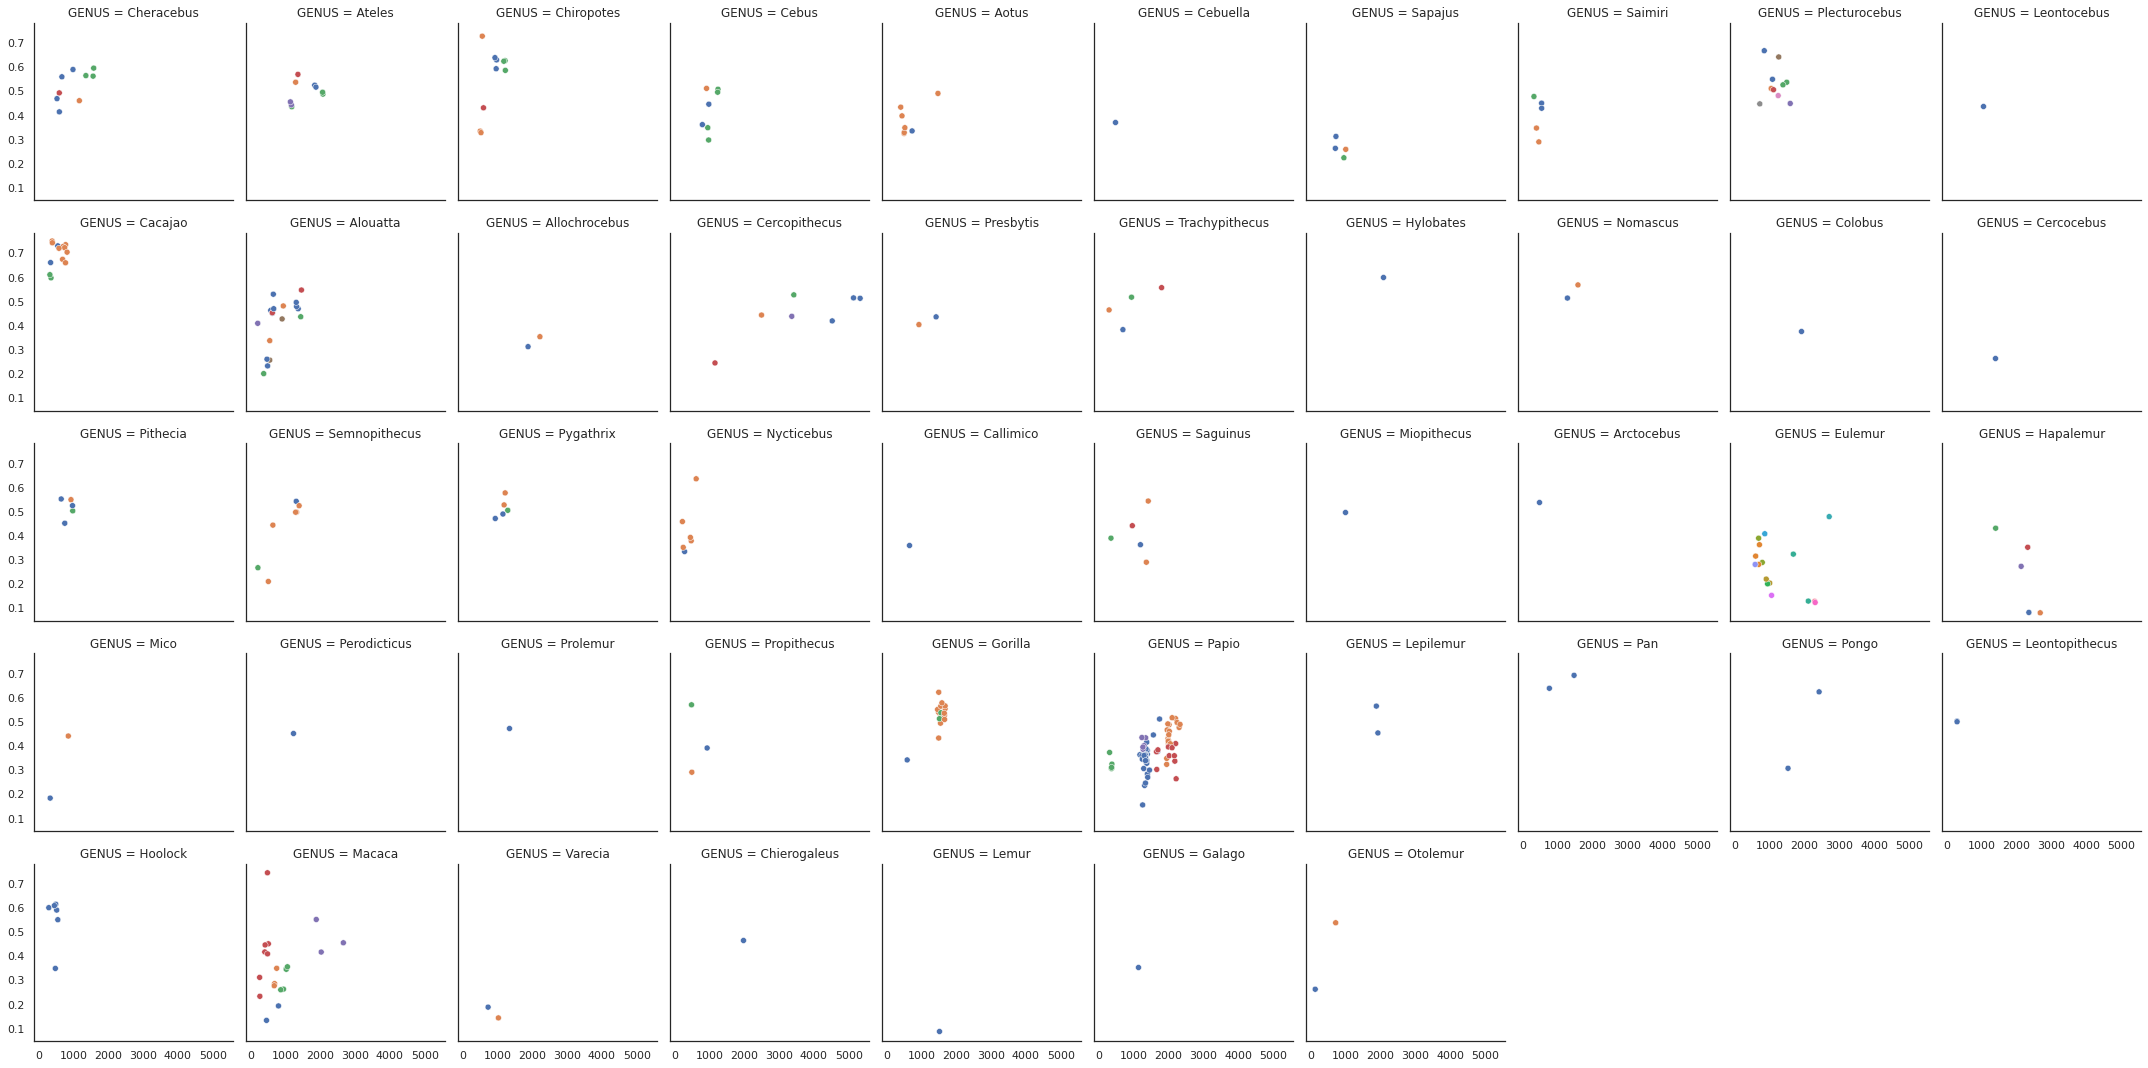

In [27]:
g = sns.FacetGrid(data=meta_present_trim, col="GENUS", col_wrap = 10)
g.map_dataframe(sns.scatterplot, x="aut_het", y="x_a_ratio", hue="SPECIES")

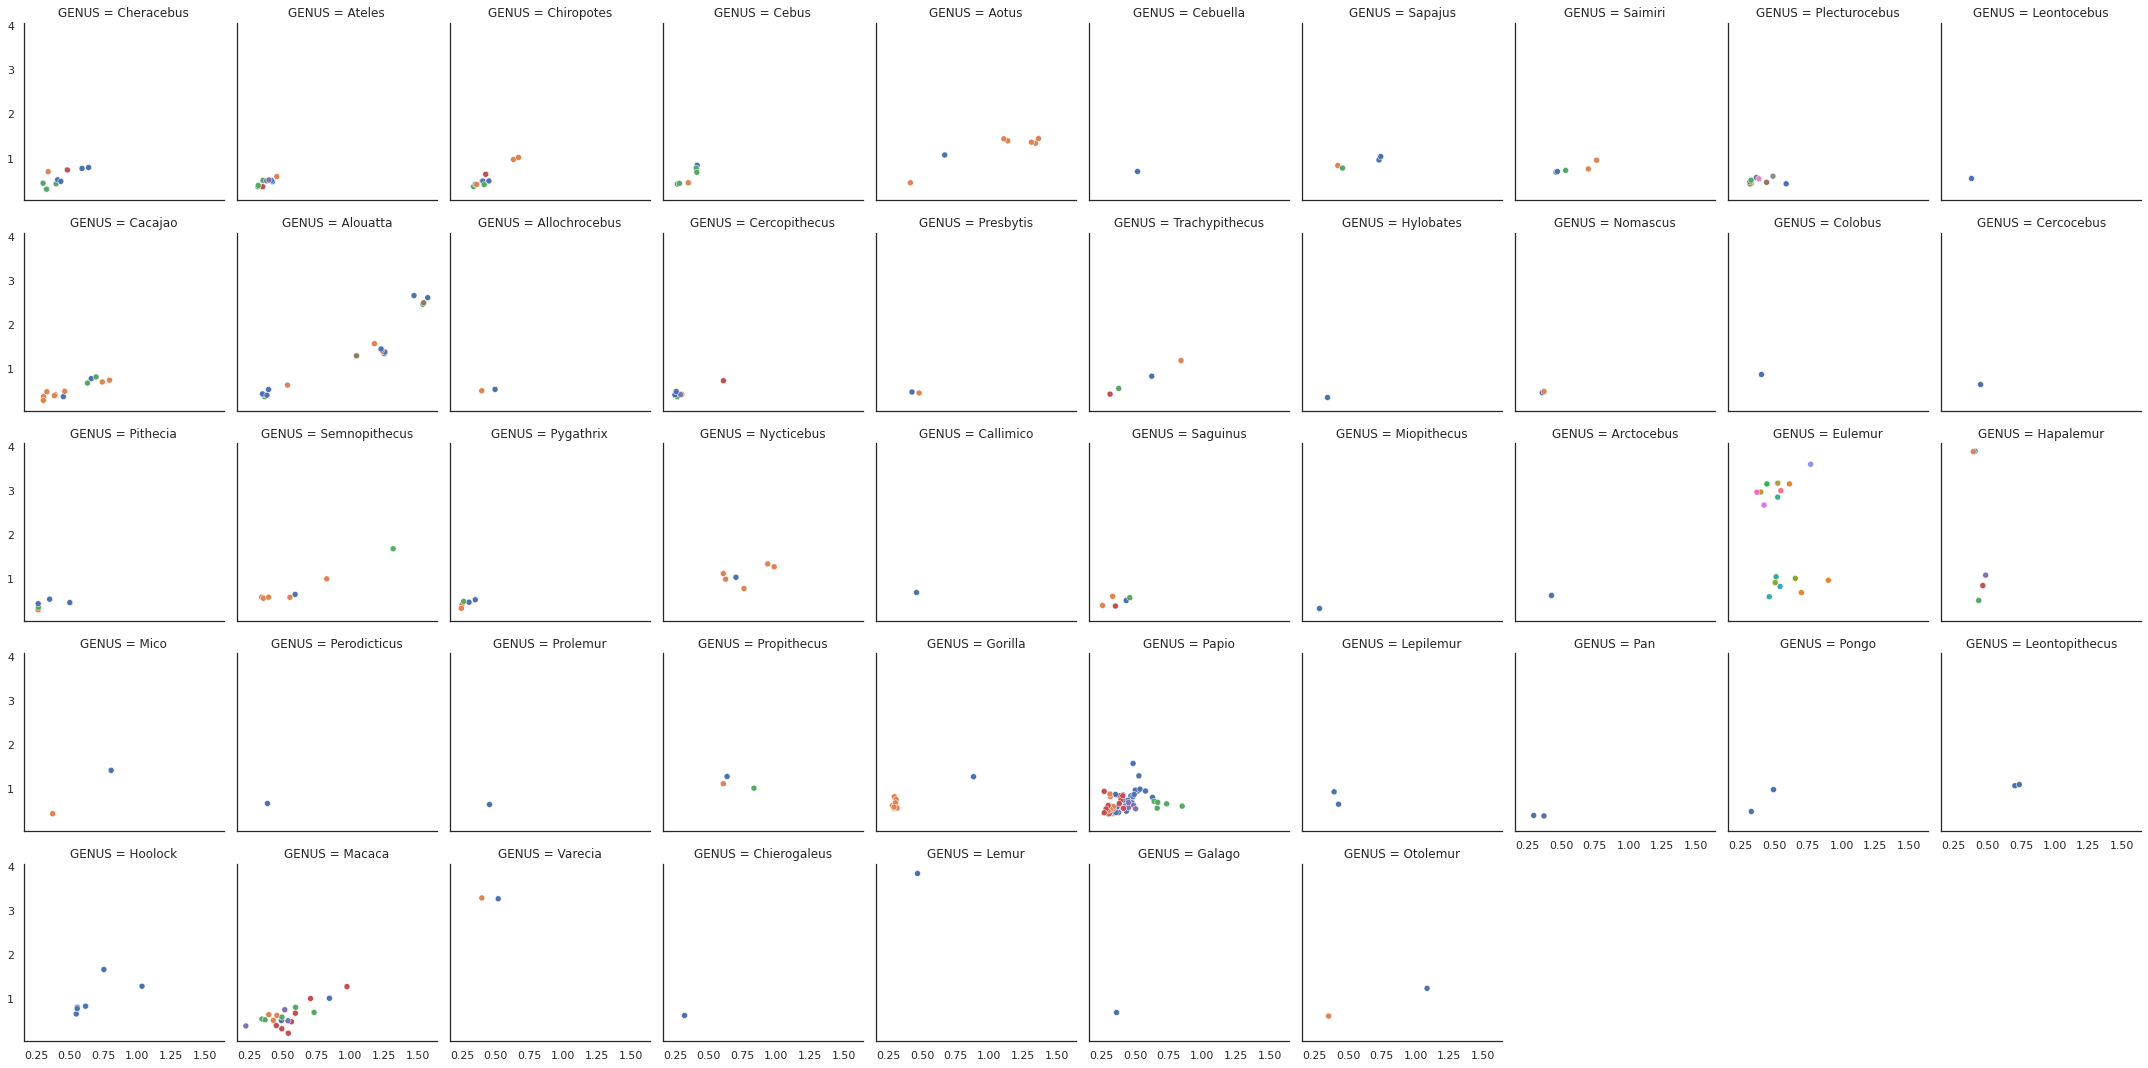

In [28]:
g = sns.FacetGrid(data=meta_present_trim, col="GENUS", col_wrap = 10)
g.map_dataframe(sns.scatterplot, x="CV_aut", y="CV_x", hue="SPECIES")

In [29]:
meta_present_trim

,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID,PGDP_ID,SEX,x_a_ratio,...,std_aut,std_x,CV_x,CV_aut,nomatch_size_x,prune_size_x,keep_size_x,nomatch_size_aut,prune_size_aut,keep_size_aut
0,PD_0001,Cheracebus,lugens,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.fasta,PD_0001,F,0.413305,...,382.557661,193.983490,0.784732,0.639623,12.369863,13,132,32.136691,192,2449
3,PD_0004,Ateles,belzebuth,PASS,PASS,Ateles_geoffroyi,Ateles_geoffroyi.bgi.fa,PD_0004,F,0.523932,...,779.888192,450.035448,0.466538,0.423592,56.958904,11,134,121.695191,161,2480
5,PD_0006,Chiropotes,israelita,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.bgi.fa,PD_0006,F,0.592055,...,385.488113,274.720937,0.481281,0.399835,30.376712,12,133,57.263158,165,2476
6,PD_0007,Cebus,olivaceus,PASS,PASS,Cebus_albifrons,Cebus_albifrons.bgi.fa,PD_0007,F,0.445075,...,343.884369,191.624435,0.437857,0.349726,28.945205,14,131,72.066263,147,2494
7,PD_0008,Aotus,trivirgatus,PASS,PASS,Aotus_nancymaae,Aotus_nancymaae.fasta,PD_0008,F,0.334245,...,489.531919,261.690865,1.069184,0.668514,14.910959,13,132,47.092011,206,2435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,PD_0838,Macaca,fascicularis,PASS,WARN,Macaca_mulatta,Macaca_mulatta.fasta,PD_0838,F,0.550941,...,1014.468792,522.265190,0.502776,0.538056,40.054795,10,135,77.074593,261,2380
694,PD_0842,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta,PD_0842,F,0.377860,...,289.437331,200.288964,1.111396,0.606872,28.993151,0,145,74.926543,175,2466
695,PD_0843,Trachypithecus,vetulus,PASS,PASS,Trachypithecus_phayrei,Trachypithecus_phayrei.fasta,PD_0843,F,0.555947,...,568.721053,414.889438,0.412865,0.314636,36.739726,11,134,77.376373,166,2475
697,PD_0845,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta,PD_0845,F,0.634955,...,470.912780,303.721640,0.771799,0.759822,59.986301,0,145,103.662249,0,2641


Text(0.5, 1.0, 'Based on 297 females')

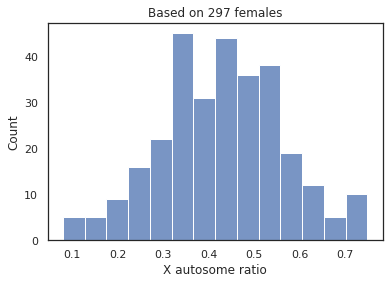

In [30]:
g = sns.histplot(data=meta_present_trim, x="x_a_ratio")
g.set_xlabel("X autosome ratio")
g.set_title("Based on 297 females")

<AxesSubplot:xlabel='CV_x', ylabel='Count'>

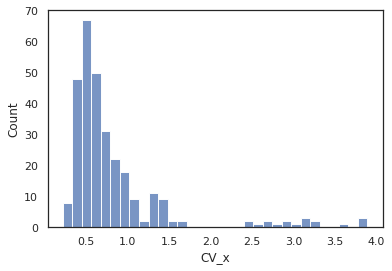

In [31]:
sns.histplot(data=meta_present_trim, x="CV_x")

<AxesSubplot:xlabel='aut_het', ylabel='x_a_ratio'>

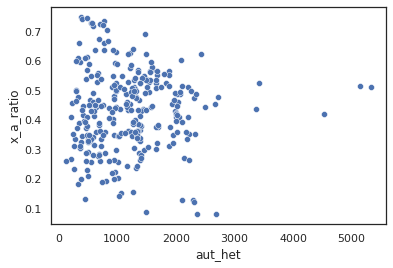

In [32]:
sns.scatterplot(data=meta_present_trim, x="aut_het", y="x_a_ratio")

<AxesSubplot:xlabel='CV_aut', ylabel='CV_x'>

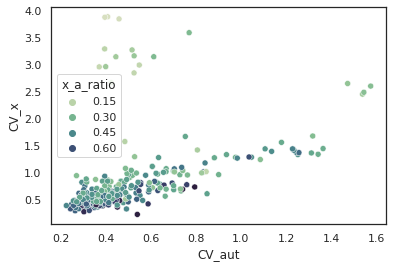

In [46]:
sns.scatterplot(data=meta_present_trim, x="CV_aut", y="CV_x", hue="x_a_ratio",
                palette=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))

In [37]:
kasper_subset = meta_present_trim.loc[(meta_present_trim.CV_aut < 1.4) & (meta_present_trim.CV_x < 2)]

<AxesSubplot:xlabel='CV_aut', ylabel='x_a_ratio'>

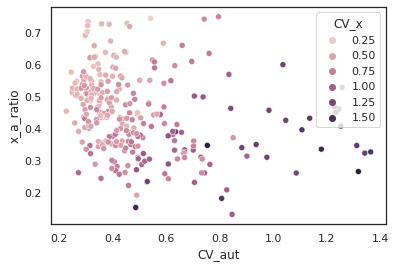

In [38]:
sns.scatterplot(data=kasper_subset, x="CV_aut", y="x_a_ratio", hue="CV_x")

In [47]:
def abline(slope, intercept, ax=None):
    "Add a straight line through the plot"
    if ax is None:
        ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='grey')

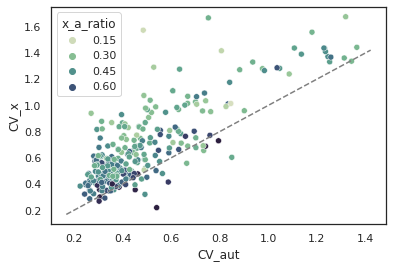

In [48]:
sns.scatterplot(data=kasper_subset, x="CV_aut", y="CV_x", hue="x_a_ratio",
                palette=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
abline(1,0)

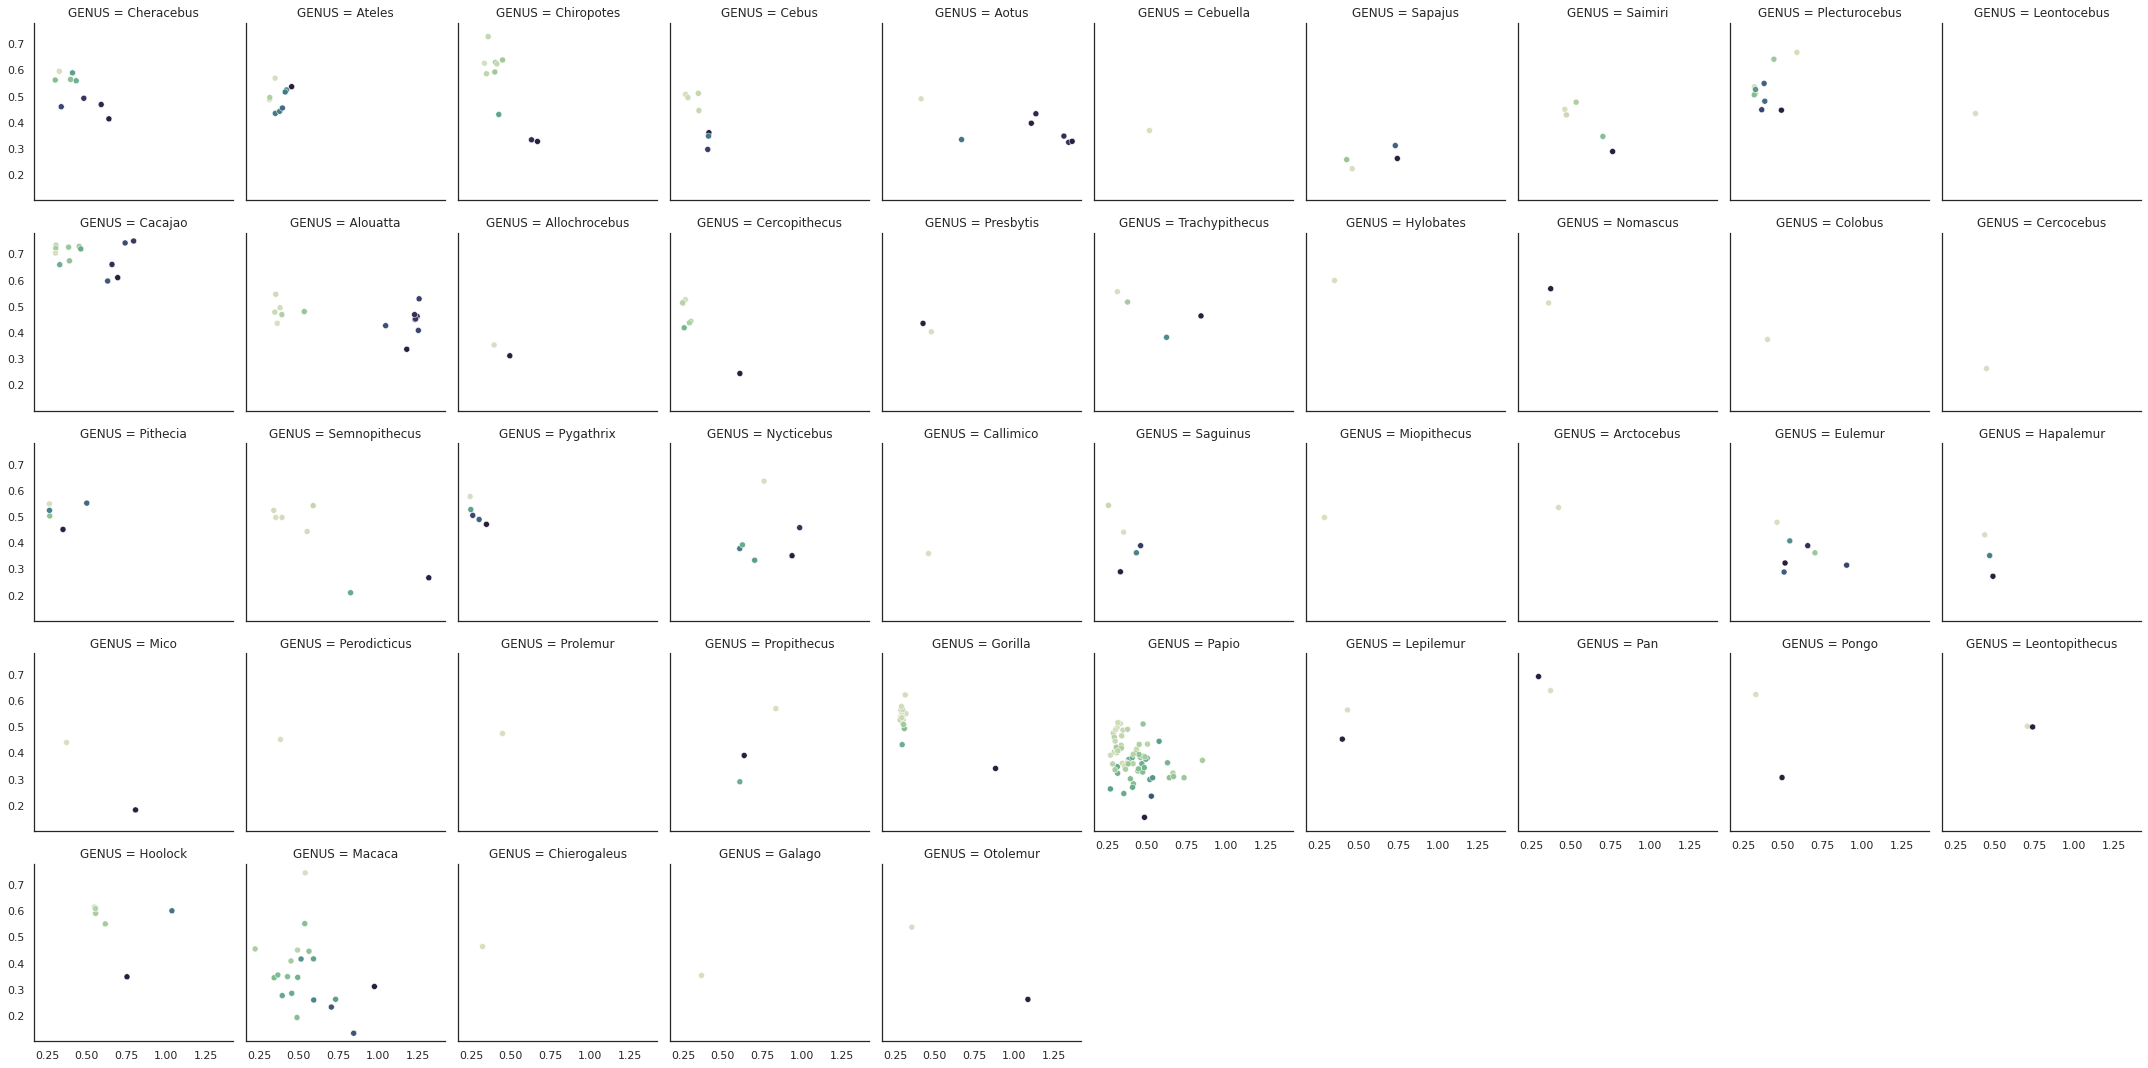

In [49]:
g = sns.FacetGrid(data=kasper_subset, col="GENUS", col_wrap = 10)
g.map_dataframe(sns.scatterplot, x="CV_aut", y="x_a_ratio", hue="CV_x",
                palette=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))

In [35]:
len(meta_present_trim.SPECIES.unique())

120

Loading testes dataset

In [36]:
res_test = pd.read_excel("../data/residuals_testes.xlsx")
res_test["GENUS"] = [x.split("_")[0].strip() for x in res_test.spc]
res_test["SPECIES"] = [x.split("_")[1].strip() for x in res_test.spc]

In [37]:
mean_x_a = []
mean_aut = []
number_inds = []
for genus in res_test.GENUS.unique():
    for species in res_test.loc[res_test.GENUS == genus].SPECIES:
        df_sub = meta_present_trim.loc[(meta_present_trim.GENUS == genus) & (meta_present_trim.SPECIES == species)]
        if len(df_sub) <= 0:
            mean_x_a.append(np.NAN)
            mean_aut.append(np.NAN)
            number_inds.append(np.NAN)
        else:
            mean_x_a.append(df_sub.x_a_ratio.mean())
            mean_aut.append(df_sub.aut_het.mean())
            number_inds.append(len(df_sub))
res_test["mean_x_a_ratio"] = mean_x_a
res_test["aut_het"] = mean_aut
res_test["inds"] = number_inds

In [38]:
meta_present_trim.loc[meta_present_trim.SPECIES == "sp."].PGDP_ID.values

array(['PD_0017', 'PD_0194', 'PD_0195', 'PD_0262', 'PD_0263', 'PD_0345',
       'PD_0352', 'PD_0367', 'PD_0387'], dtype=object)

In [39]:
meta_present_trim.SPECIES.unique()

array(['lugens', 'belzebuth', 'israelita', 'olivaceus', 'trivirgatus',
       'pygmaea', 'macrocephalus', 'ustus', 'unicolor', 'cupreus', 'sp.',
       'melanocephalus', 'calvus', 'ayresi', 'seniculus', 'puruensis',
       'belzebul', 'lhoesti', 'preussi', 'ascanius', 'mitrata', 'mona',
       'crepusculus', 'agilis', 'gabriellae', 'comata', 'polykomos',
       'hamlyni', 'albogularis', 'chrysogaster', 'juara', 'marginatus',
       'albinasus', 'sagulatus', 'irrorata', 'albicans', 'roloway',
       'siki', 'priam', 'entellus', 'nemaeus', 'pygmaeus', 'nigripes',
       'goeldii', 'imperator', 'midas', 'oedipus', 'ogouensis', 'chamek',
       'albifrons', 'hirsuta', 'calabarensis', 'collaris', 'coronatus',
       'flavifrons', 'macaco', 'sanfordi', 'gilberti', 'griseus',
       'meridionalis', 'occidentalis', 'argentatus', 'ibeanus', 'simus',
       'diadema', 'edwardsi', 'tattersalli', 'palliata', 'geoffroyi',
       'beringeri ', 'gorilla', 'anubis', 'cynocephalus', 'ankaranensis',
   

In [40]:
len(res_test.SPECIES)

55

In [41]:
len(res_test.dropna())

27

<AxesSubplot:xlabel='CombinedTestesMass.in.g', ylabel='mean_x_a_ratio'>

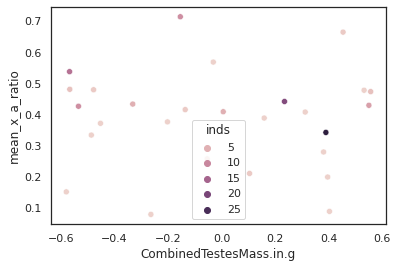

In [42]:
sns.scatterplot(data=res_test, x = "CombinedTestesMass.in.g", y = "mean_x_a_ratio", hue="inds")

<AxesSubplot:xlabel='aut_het', ylabel='mean_x_a_ratio'>

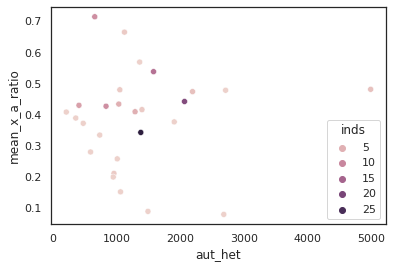

In [43]:
sns.scatterplot(data=res_test, x = "aut_het", y = "mean_x_a_ratio", hue="inds")

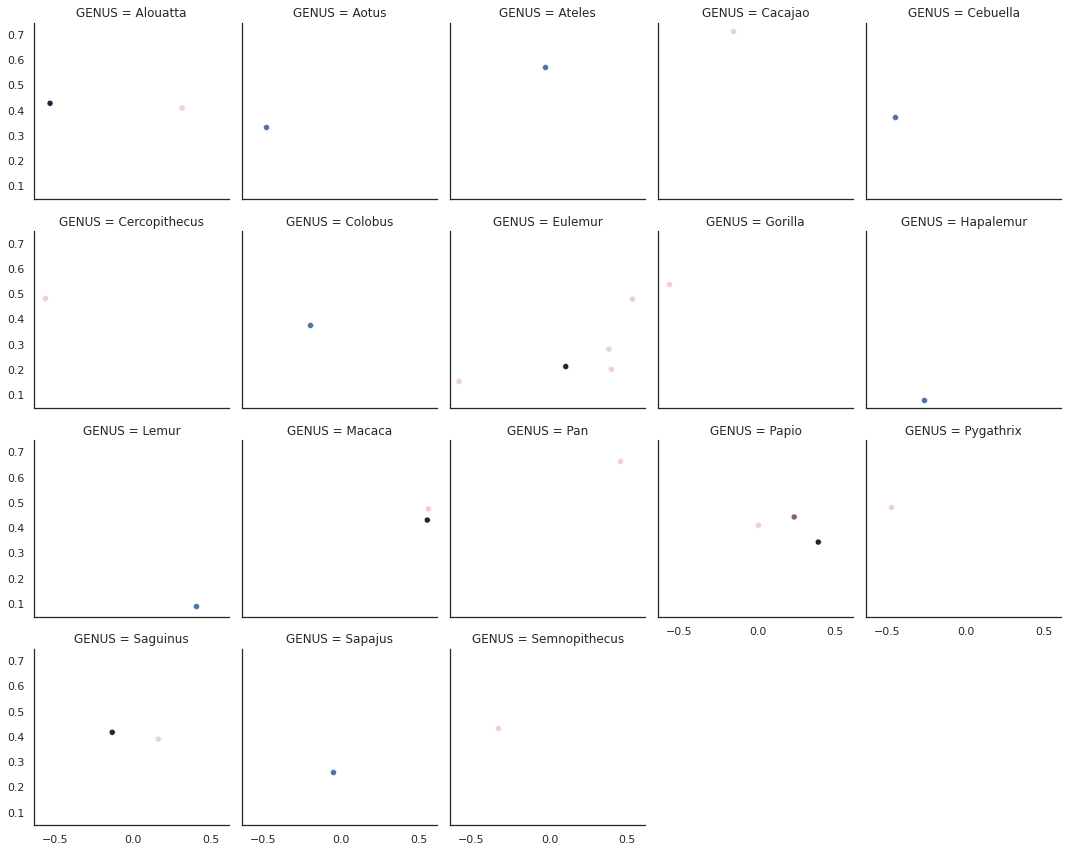

In [44]:
g = sns.FacetGrid(data=res_test.dropna(), col="GENUS", col_wrap = 5)
g.map_dataframe(sns.scatterplot, x="CombinedTestesMass.in.g", y="mean_x_a_ratio", hue="inds")

Alternate implementation for lm

In [45]:
res_test = pd.read_excel("../data/residuals_testes.xlsx")
res_test["GENUS"] = [x.split("_")[0].strip() for x in res_test.spc]
res_test["SPECIES"] = [x.split("_")[1].strip() for x in res_test.spc]

In [46]:
meta_testes = res_test.merge(meta_present_trim, on=["SPECIES"])

In [47]:
meta_testes.columns

Index(['spc', 'CombinedTestesMass.in.g', 'GENUS_x', 'SPECIES', 'PDGP_ID',
       'GENUS_y', 'AB_QC', 'COV_QC', 'REFERENCE_SPECIES',
       'REFERENCE_ASSEMBLY_ID', 'PGDP_ID', 'SEX', 'x_a_ratio', 'aut_het',
       'x_het', 'std_aut', 'std_x', 'CV_x', 'CV_aut', 'nomatch_size_x',
       'prune_size_x', 'keep_size_x', 'nomatch_size_aut', 'prune_size_aut',
       'keep_size_aut'],
      dtype='object')

In [48]:
from sklearn import linear_model

In [49]:
X = meta_testes[['x_a_ratio', 'aut_het',
       'x_het', 'std_aut', 'std_x', 'CV_x', 'CV_aut']]
y = meta_testes['CombinedTestesMass.in.g']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
print(lm.score(X,y), lm.coef_)

0.29149846219420383 [-6.39379016e-01 -1.99900967e-04  4.38269976e-05  1.50570244e-03
 -1.55418827e-03  5.03976569e-02 -9.02746005e-01]


In [50]:
lm.score(X, y, sample_weight=None)

0.29149846219420383

In [51]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=2, step=1)
selector = selector.fit(X, y)
selector.ranking_

array([1, 5, 3, 6, 4, 1, 2])

In [52]:
X = meta_testes[['x_a_ratio', 'CV_x']]
y = meta_testes['CombinedTestesMass.in.g']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
print(lm.score(X,y), lm.coef_)

0.14478091204932486 [-1.39303273 -0.18413037]


In [66]:
X = kasper_subset[['CV_x', 'CV_aut']]
y = kasper_subset['x_a_ratio']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
print(lm.score(X,y), lm.coef_)

0.28380954035133965 [-0.32597401  0.20180317]


Look a bit into Macaca - there are some weird individuals which somehow have been included.
They were removed in the earlier method, as they had too little data.
There are also some other outliers, which I probably should investigate a bit more.

In [53]:
meta_present.loc[meta_present.GENUS == "Lemur"]

,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID,PGDP_ID,SEX,x_a_ratio,...,std_aut,std_x,CV_x,CV_aut,nomatch_size_x,prune_size_x,keep_size_x,nomatch_size_aut,prune_size_aut,keep_size_aut
533,PD_0620,Lemur,catta,PASS,PASS,Lemur_catta-Thomas,Lemur_catta-Thomas.fasta,PD_0620,F,0.089157,...,685.355367,511.784417,3.849201,0.459574,23.623288,0,145,203.055282,144,2497


<AxesSubplot:xlabel='aut_het', ylabel='x_a_ratio'>

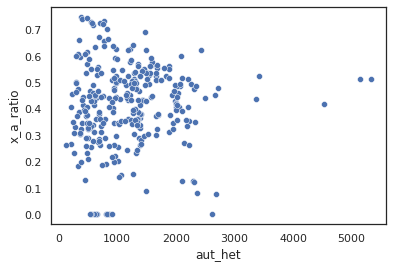

In [54]:
sns.scatterplot(data=meta_present, x="aut_het", y="x_a_ratio")

In [55]:
mb_mask.loc[(mb_mask.PGDP_ID == "PD_0834") & (mb_mask.chrtype == "chrX")]
#PD_0833 has practically no data on X, PD_0837 has a lot.

,lines,GQ_pass,ADFrac_pass,both_pass,PGDP_ID,species,match_type,chr,window,chrtype,mask_percentage
5848950,0,0,0,0,PD_0834,Macaca_mulatta,nomatch,chrX,0,chrX,0.782829
5849411,1,1,1,1,PD_0834,Macaca_mulatta,refmatch,chrX,0,chrX,0.782829
5850088,0,0,0,0,PD_0834,Macaca_mulatta,altmatch,chrX,0,chrX,0.782829
5850984,0,0,0,0,PD_0834,Macaca_mulatta,nomatch,chrX,1000000,chrX,0.922657
5851445,0,0,0,0,PD_0834,Macaca_mulatta,refmatch,chrX,1000000,chrX,0.922657
...,...,...,...,...,...,...,...,...,...,...,...
6154166,0,0,0,0,PD_0834,Macaca_mulatta,refmatch,chrX,150000000,chrX,0.998142
6156172,0,0,0,0,PD_0834,Macaca_mulatta,refmatch,chrX,151000000,chrX,0.992885
6158178,0,0,0,0,PD_0834,Macaca_mulatta,refmatch,chrX,152000000,chrX,0.996174
6160184,0,0,0,0,PD_0834,Macaca_mulatta,refmatch,chrX,153000000,chrX,0.997508


In [56]:
mb_mask.loc[(mb_mask.PGDP_ID == "PD_0620") & (mb_mask.chrtype == "chrX")]

,lines,GQ_pass,ADFrac_pass,both_pass,PGDP_ID,species,match_type,chr,window,chrtype,mask_percentage
5849175,998,992,656,656,PD_0620,Lemur_catta,refmatch,chrX,0,chrX,0.782829
5850046,869,856,480,480,PD_0620,Lemur_catta,altmatch,chrX,0,chrX,0.782829
5850059,474,469,294,294,PD_0620,Lemur_catta,nomatch,chrX,0,chrX,0.782829
5851209,1022,1002,743,743,PD_0620,Lemur_catta,refmatch,chrX,1000000,chrX,0.922657
5852080,818,802,518,518,PD_0620,Lemur_catta,altmatch,chrX,1000000,chrX,0.922657
...,...,...,...,...,...,...,...,...,...,...,...
6164822,112,36,21,21,PD_0620,Lemur_catta,altmatch,chrX,155000000,chrX,0.986408
6164835,34,14,12,12,PD_0620,Lemur_catta,nomatch,chrX,155000000,chrX,0.986408
6165894,8,7,5,5,PD_0620,Lemur_catta,refmatch,chrX,156000000,chrX,0.026236
6166677,8,8,3,3,PD_0620,Lemur_catta,altmatch,chrX,156000000,chrX,0.026236
